# **IMPORT LIBS**

In [24]:
import keras
from keras import layers
import pandas as pd
import numpy as np
import warnings
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
#from skimage.transform import rotate, shear, zoom
#from imgaug import augmenters as iaa
import tensorflow as tf
import math

import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

warnings.filterwarnings('ignore')

# **AUX FUNCTIONS**

In [11]:
def save_manovers_positions_to_csv_file(gps_positions, manovers, filename):
  output = np.zeros_like(gps_positions)

  # Iterate through the elements of arr2
  for i in range(len(manovers)):
    # Check if the element in arr2 is 1
    if manovers[i] == 1:
      # Copy the corresponding values from arr1 to the output array
      output[i] = gps_positions[i]

  output = output[~np.all(output == 0, axis=1)]
  np.savetxt(filename, output, delimiter=',', fmt='%.9f')



def separate_positives_negatives(data):
  # Ensure the input is converted to a NumPy array for easier manipulation
  data = np.array(data)

  # Create two empty arrays to store positive and negative values
  positives = np.zeros_like(data)
  negatives = np.zeros_like(data)

  # Use boolean indexing to separate positive and negative values
  positives[data > 0] = data[data > 0]
  negatives[data < 0] = -data[data < 0]

  # Combine the positive and negative values into a single 2D array
  return (positives, negatives)

def normalize_between_0_and_max(data):
  max_value = np.max(data)
  return data / max_value

def normalize_between_0_and_max_v2(data, max_value):
  return data / max_value

def split_train_test(data, test_size=0.2):
  # Check if test_size is between 0 and 1
  if test_size < 0 or test_size > 1:
    raise ValueError("test_size must be between 0 and 1.")

  # Get the number of samples
  num_samples = data.shape[0]

  # Calculate the number of samples for each set
  train_size = int(num_samples * (1 - test_size))
  test_size = num_samples - train_size

  # Randomly shuffle the data for better splitting (optional)
  #np.random.shuffle(data)

  # Split the data into training and test sets
  train_data = data[:train_size]
  test_data = data[train_size:]

  return train_data, test_data

def y_classification(data, threshold):
  classification = np.zeros_like(data, dtype=int)  # Initialize output array

  for col in range(0, 12):  # Loop through each column
    max_value = np.max(data[:, col])
    threshold_pos = max_value * threshold
    classification[:, col] = np.where(data[:, col] >= threshold_pos, 1, 0)

  return classification

def max_of_vectors(vec1, vec2, vec3, vec4, vec5, vec6):
  # Combine all vectors into a single array
  all_vectors = np.array([vec1, vec2, vec3, vec4, vec5, vec6])

  # Find the maximum value in the array
  max_value = np.max(all_vectors)

  return max_value

def random_aug_op(data, columnName):
  random_number = np.random.rand()

  if random_number < 0.5:
    #data = data - data*0.05
    data = data - data*random_number
  else:
    #data = data + data*0.05
    data = data + data*(1-random_number)

  return data
  #newrow = pd.DataFrame({columnName: [data]})
  #newrow = pd.DataFrame([data])
  #return newrow

def tabular_dataaugmentation(data):
  augmented_data = data.copy()
  augmented_data_list = augmented_data.to_numpy()
  print(augmented_data_list)

  for i in data:
    for j in range(10):
      #augmented_data = pd.concat([augmented_data, random_aug_op(i, data.name)])
      #augmented_data_list.append(random_aug_op(i, data.name))
      augmented_data_list = np.append(augmented_data_list, random_aug_op(i, data.name))

  #return augmented_data
  #return pd.DataFrame(augmented_data_list).drop(0).reset_index(drop=True)
  dataframe = pd.DataFrame(augmented_data_list)
  finaldataframe = dataframe[0]
  return finaldataframe

# **IMPORT DATA**

In [14]:
df = pd.read_csv('../../dataset/Abrantes-Leiria.csv')

acelX = df['accelerometerXAxis']
acelY = df['accelerometerYAxis']
acelZ = df['accelerometerZAxis']

gyrX = df['gyroscopeXAxis']
gyrY = df['gyroscopeYAxis']
gyrZ = df['gyroscopeZAxis']

latitude = df['latitude']
longitude = df['longitude']

# **DATA AUGEMTATION**

In [ ]:
#acelXaug = tabular_dataaugmentation(acelX)
#print(acelX.shape)
#print(acelXaug.shape)
#acelYaug = tabular_dataaugmentation(acelY)
#acelZaug = tabular_dataaugmentation(acelZ)
#gyrXaug = tabular_dataaugmentation(gyrX)
#gyrYaug = tabular_dataaugmentation(gyrY)
#gyrZaug = tabular_dataaugmentation(gyrZ)
#
#latitudeaug = tabular_dataaugmentation(latitude)
#longitudeaug = tabular_dataaugmentation(longitude)

# **SEPARATE DATA BY MANOVER**

In [15]:
turnRightX, turnLeftX = separate_positives_negatives(acelX)
#turnRightX, turnLeftX = separate_positives_negatives(acelXaug)

accelY, breakY = separate_positives_negatives(acelY)
#accelY, breakY = separate_positives_negatives(acelYaug)

positiveZ, negativeZ = separate_positives_negatives(acelZ)
#positiveZ, negativeZ = separate_positives_negatives(acelZaug)

gyrPositiveX, gyrNegativeX = separate_positives_negatives(gyrX)
#gyrPositiveX, gyrNegativeX = separate_positives_negatives(gyrXaug)

gyrPositiveY, gyrNegativeY = separate_positives_negatives(gyrY)
#gyrPositiveY, gyrNegativeY = separate_positives_negatives(gyrYaug)

gyrPositiveZ, gyrNegativeZ = separate_positives_negatives(gyrZ)
#gyrPositiveZ, gyrNegativeZ = separate_positives_negatives(gyrZaug)

# **CLASSIFICATION BASED ON NOT NORMALIZED VALUES**

In [16]:
newArray1 = np.array(list(zip(turnRightX, turnLeftX, accelY, breakY, positiveZ, negativeZ, gyrPositiveX, gyrNegativeX, gyrPositiveY, gyrNegativeY, gyrPositiveZ, gyrNegativeZ)))

y = y_classification(newArray1, 0.3)
print (np.sum(y, axis=0))
np.savetxt("Y.csv", y, delimiter=',', fmt='%.0i')

[ 945  836  714  157  259  115  421  687  719  712 1144  375]


# **NORMALIZE DATA**

In [17]:
max_accel = max_of_vectors(turnRightX, turnLeftX, accelY, breakY, positiveZ, negativeZ)
max_gyr = max_of_vectors(gyrPositiveX, gyrNegativeX, gyrPositiveY, gyrNegativeY, gyrPositiveZ, gyrNegativeZ)

In [18]:
turnRightXn = normalize_between_0_and_max_v2(turnRightX, max_accel)
turnLeftXn = normalize_between_0_and_max_v2(turnLeftX, max_accel)
accelYn = normalize_between_0_and_max_v2(accelY, max_accel)
breakYn = normalize_between_0_and_max_v2(breakY, max_accel)
positiveZn = normalize_between_0_and_max_v2(positiveZ, max_accel)
negativeZn = normalize_between_0_and_max_v2(negativeZ, max_accel)
gyrPositiveXn = normalize_between_0_and_max_v2(gyrPositiveX, max_gyr)
gyrNegativeXn = normalize_between_0_and_max_v2(gyrNegativeX, max_gyr)
gyrPositiveYn = normalize_between_0_and_max_v2(gyrPositiveY, max_gyr)
gyrNegativeYn = normalize_between_0_and_max_v2(gyrNegativeY, max_gyr)
gyrPositiveZn = normalize_between_0_and_max_v2(gyrPositiveZ, max_gyr)
gyrNegativeZn = normalize_between_0_and_max_v2(gyrNegativeZ, max_gyr)

# **CREATE AN ARRAY WITH ALL DATA**

In [19]:
newArray = np.array(list(zip(turnRightXn, turnLeftXn, accelYn, breakYn, positiveZn, negativeZn, gyrPositiveXn, gyrNegativeXn, gyrPositiveYn, gyrNegativeYn, gyrPositiveZn, gyrNegativeZn)))

# **SHOW MANOVERS ON GOOLGE MAP**

In [20]:
positions = np.array(list(zip(latitude, longitude)))
manover_accelY = y[:, 2]
print(manover_accelY)
manover_breakY = y[:, 3]
manover_turnRightXn = y[:, 0]
manover_turnLeftXn = y[:, 1]
gyrPositiveZn = y[:, 10]
gyrNegativeZn = y[:, 11]
save_manovers_positions_to_csv_file(positions, manover_accelY, "accelY.csv")
save_manovers_positions_to_csv_file(positions, manover_breakY, "breakY.csv")
save_manovers_positions_to_csv_file(positions, manover_turnRightXn, "turnRightX.csv")
save_manovers_positions_to_csv_file(positions, manover_turnLeftXn, "turnLeftX.csv")
save_manovers_positions_to_csv_file(positions, gyrPositiveZn, "gyrPositZ.csv")
save_manovers_positions_to_csv_file(positions, gyrNegativeZn, "gyrNegZ.csv")

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

# **PLOT MANOVERS**

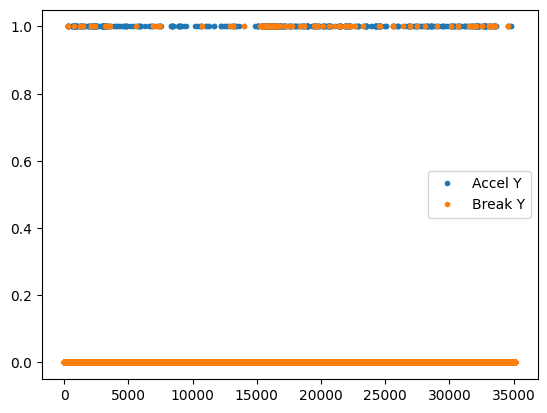

In [21]:
plt.plot(y[:, 2], marker='.', linestyle='none')
plt.plot(y[:, 3], marker='.', linestyle='none')

plt.legend(['Accel Y', 'Break Y'])
plt.show()

# **SEPARATE DATA IN TRAIN AND TEST**

In [22]:
x_treino, x_teste = split_train_test(newArray, test_size=0.2)


y_treino, y_teste = split_train_test(y, test_size=0.2)

# **CREATE THE INPUT TENSORES DATA**

In [23]:
treino = x_treino.reshape(x_treino.shape[0], 1, x_treino.shape[1])
teste = x_teste.reshape(x_teste.shape[0], 1, x_teste.shape[1])

# **CREATE TRANSFORMER BLOCK**

In [25]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

# **CREATE THE MODEL**

In [37]:
n_classes = y.shape[1]


def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [40]:
input_shape = treino.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)

model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 1, 12)]              0         []                            
                                                                                                  
 multi_head_attention_48 (M  (None, 1, 12)                52236     ['input_13[0][0]',            
 ultiHeadAttention)                                                  'input_13[0][0]']            
                                                                                                  
 dropout_108 (Dropout)       (None, 1, 12)                0         ['multi_head_attention_48[0][0
                                                                    ]']                           
                                                                                           

# **TRAIN THE MODEL**

In [41]:
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

model.fit(
    treino,
    y_treino,
    validation_split=0.2,
    epochs=150,
    batch_size=64,
    callbacks=callbacks,
)

model.evaluate(teste, y_teste, verbose=1)

Epoch 1/150


ValueError: in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 1155, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 1249, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 620, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/metrics_utils.py", line 77, in decorated
        result = update_state_fn(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/metrics/base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/metrics/base_metric.py", line 723, in update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/metrics/accuracy_metrics.py", line 459, in sparse_categorical_accuracy
        matches = metrics_utils.sparse_categorical_matches(y_true, y_pred)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/metrics_utils.py", line 961, in sparse_categorical_matches
        y_true = tf.squeeze(y_true, [-1])

    ValueError: Can not squeeze dim[1], expected a dimension of 1, got 12 for '{{node Squeeze}} = Squeeze[T=DT_FLOAT, squeeze_dims=[-1]](Cast_1)' with input shapes: [?,12].
